In [4]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

from numba import njit, jit


from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

0.0


/home/herbert/workspace/Thesis-VQE/TriAtomic Molecule/entanglement_measures.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_matrix[ind_i][ind_j] = Bipartite_Negativity(rho_p)


In [25]:

#@jit
def initialize_O3_vqe_chemical(intermolecular_distance= 1, angle= np.pi/2 , basis = 'ccpvdz'):

    xcoord = intermolecular_distance * np.sin(angle)
    ycoord = intermolecular_distance * np.cos(angle)

    driver = PySCFDriver(atom=f"O 0 0 0; O {-1 * xcoord} {ycoord} 0; O {xcoord} {ycoord} 0", basis=basis)

    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 4) #only two pair of ion electron pairs

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz



#@jit
def run_calculation_for_O3_gs(swept_interval, angle_interval ,estimator):

    distances = swept_interval
    angles = angle_interval

    num_dist = len( swept_interval )
    num_angl = len( angle_interval)

    shape_of_mesh = (num_angl, num_dist)

    entanglement_list_max = np.zeros(shape= shape_of_mesh)
    entanglement_list_total = np.zeros(shape= shape_of_mesh)

    negativity_list_max = np.zeros(shape= shape_of_mesh)
    negativity_list_total = np.zeros(shape= shape_of_mesh)

    ghz_measure_list = np.zeros(shape= shape_of_mesh)

    energiesH2_list = np.zeros(shape= shape_of_mesh)


    for i, d in enumerate(swept_interval):
        for j, a in enumerate(angle_interval):

            ansatz_h2, pauli_ham_h2, prob = initialize_O3_vqe_chemical(intermolecular_distance= d,
                                                                       angle= a,
                                                                       basis= 'sto-3g')

            gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                                ansatz= ansatz_h2,
                                                                problem= prob)
        

            r = DensityMatrix(optimal_ansatz_d)

    

            energiesH2_list[i][j] = gs_energy_d

            entanglement_list_max[i][j]  = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
            entanglement_list_total[i][j] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
            """
            negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
            negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
            """
            ghz_measure_list[i][j]  = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

        return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

In [26]:
distances = np.linspace(0.5, 2, 30)
angles_interval = np.linspace(np.pi/2, 5 * np.pi/6, num= 30)

estimator = Estimator()


energies_O3, entgmax_O3, entgtotal_O3, negmax_O3, negtotal_O3, ghzmeasure_O3 = run_calculation_for_O3_gs(swept_interval= distances, angle_interval= angles_interval ,estimator= estimator)

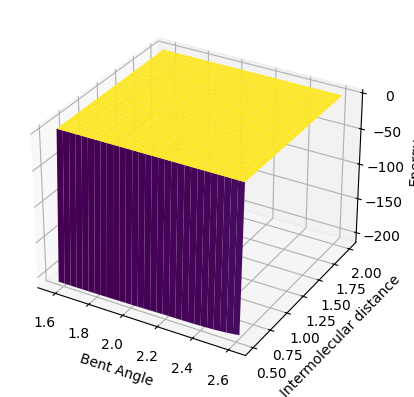

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


# Step 2: Convert the list of lists into a NumPy array
Z = np.array(energies_O3)

# Step 3: Create a meshgrid for x and y coordinates
x = angles_interval    # Number of columns
y = distances  # Number of rows
X, Y = np.meshgrid(x, y)

# Step 4: Plot the 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels (optional)
ax.set_xlabel('Bent Angle')
ax.set_ylabel('Intermolecular distance')
ax.set_zlabel('Energy')

# Show the plot
plt.show()

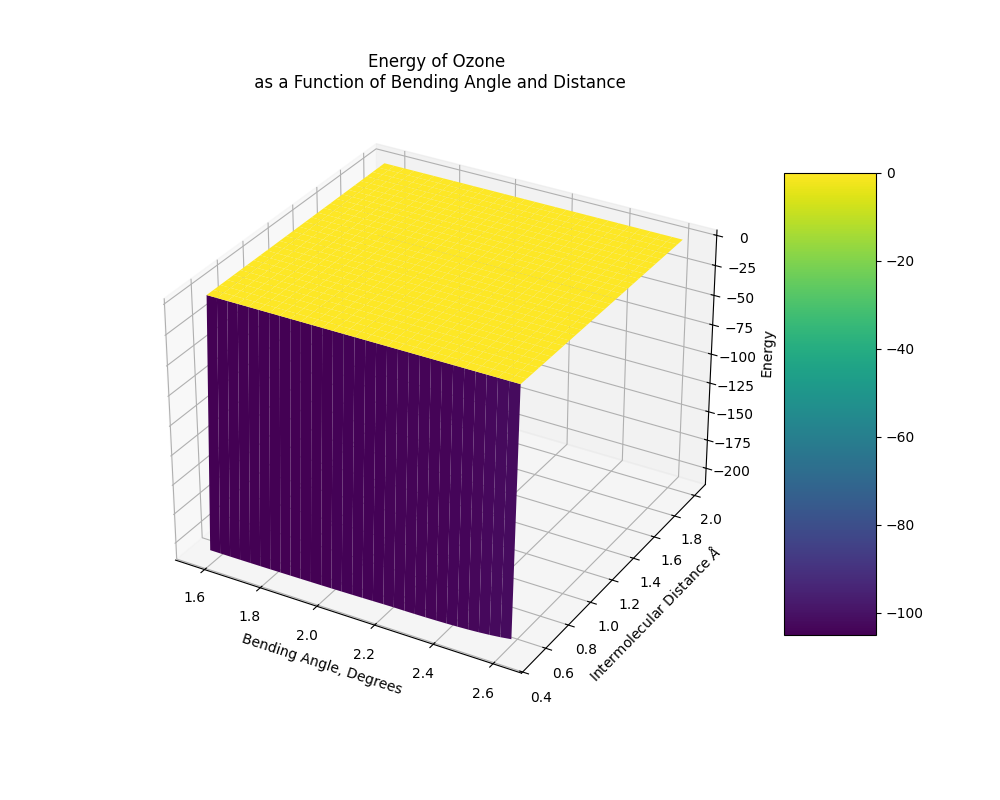

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib widget




fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')



angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = energies_O3

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, Degrees')
ax.set_ylabel(r'Intermolecular Distance $\AA$')
ax.set_zlabel('Energy')
ax.set_title('Energy of Ozone\n as a Function of Bending Angle and Distance')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.75, aspect=5)

plt.show()

In [15]:
distances = np.linspace(0.8, 1.3, 45)
angles_interval = np.linspace(5*np.pi /9, 0.72 * np.pi ,  num= 45) #from 100 to 130 degrees

estimator = Estimator()


energies_O3_pt2, entgmax_O3_pt2, entgtotal_O3_pt2, negmax_O3_pt2, negtotal_O3_pt2, ghzmeasure_O3_pt2 = run_calculation_for_O3_gs(swept_interval= distances, angle_interval= angles_interval ,estimator= estimator)

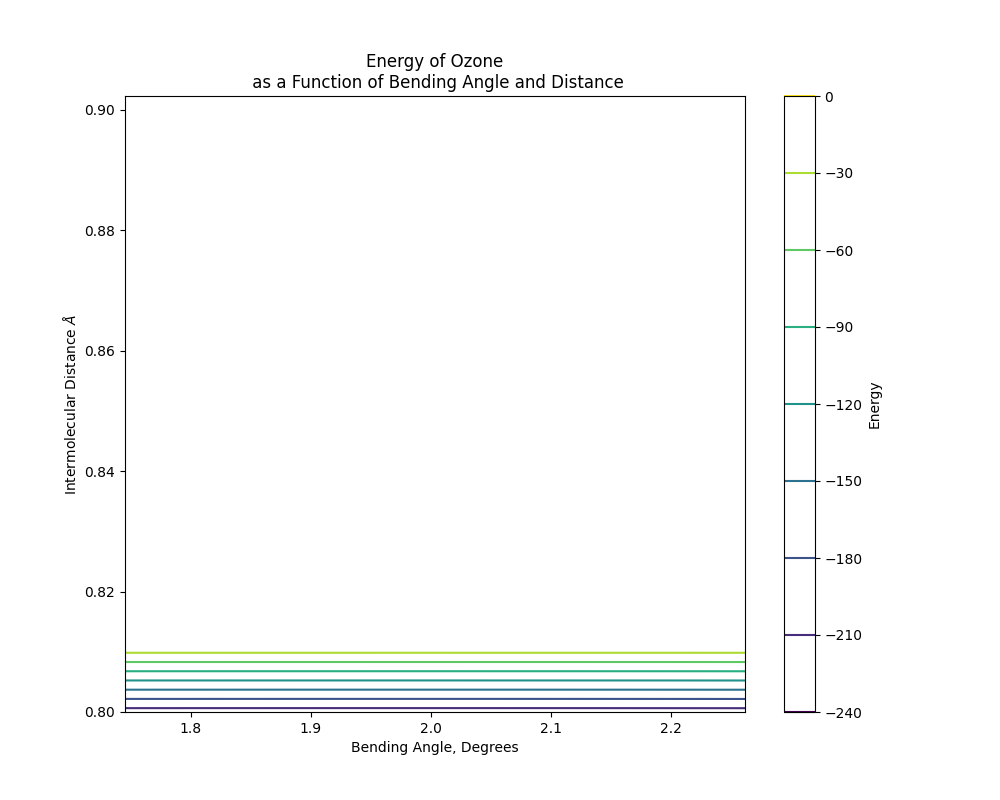

In [23]:
%matplotlib widget


# Add color bar
#%matplotlib widget

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()



angles_grid, distances_grid = np.meshgrid(angles_interval, distances[0:10])

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method
energies = energies_O3_pt2[:][0:10]

# Plot surface
#surf = ax.plot_surface(angles_grid, distances_grid, energies, cmap='viridis')

contour = ax.contour(angles_grid, distances_grid, energies, cmap= 'viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, Degrees')
ax.set_ylabel(r'Intermolecular Distance $\AA$')
#ax.set_zlabel('Energy')
ax.set_title('Energy of Ozone\n as a Function of Bending Angle and Distance')

# Add color bar
fig.colorbar(contour, label= 'Energy')
plt.show()

In [20]:
print(np.min(energies_O3_pt2))

-222.67803228462597
